### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import regex
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform
from skopt.space import Integer, Real, Categorical
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
    accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report)

In [5]:
subreddits = pd.read_csv('C:/Users/mmoli/GA/projects/project_3/data/subreddits_cleaned.csv')

In [6]:
subreddits.shape

(122978, 5)

In [7]:
# Run for production Model
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"it\'s", "its", phrase)
    phrase = re.sub(r"What\'s", "What is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    # phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

def mytokenizing_stem(column):
    words = ''
    for elements in column:
        words += elements
    tokenizer = RegexpTokenizer(r'\w+')
    words_tokens = tokenizer.tokenize(words)
    p_stemmer = PorterStemmer()
    words_tokens_stem = [p_stemmer.stem(token) for token in words_tokens]
    return words_tokens_stem

# expanding contracted text
for col in ['text']:
    subreddits['text'] = [decontracted(each) for each in subreddits[col]]

In [15]:
subreddits['subreddit_nsq'].value_counts(normalize=True)

0    0.506147
1    0.493853
Name: subreddit_nsq, dtype: float64

### Comparison MNB Model

In [75]:
X = subreddits['text']
y = subreddits['subreddit_nsq']

In [76]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [59]:
pipe = Pipeline([
    ('cv', CountVectorizer(min_df=2, tokenizer=mytokenizing_stem, max_features=9_000)),
    ('mnb', MultinomialNB(alpha=.5))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.7091930220203181, 0.689120182143438)

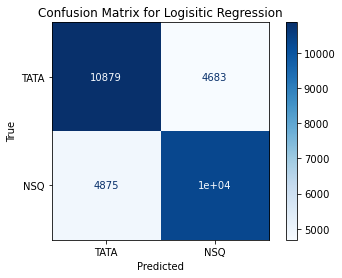

In [60]:
plot_confusion_matrix(pipe, X_test, y_test, cmap="Blues");

plt.title('Confusion Matrix for MNB');
plt.xticks(ticks=[0, 1], labels=['TATA', 'NSQ'])
plt.yticks(ticks=[0, 1], labels=['TATA', 'NSQ'])

plt.ylabel('True')
plt.xlabel('Predicted');

### Production Logistic Regression Model

In [39]:
pipe = Pipeline([
    ('cv', CountVectorizer(min_df=2, tokenizer=mytokenizing_stem, max_df=.95)), 
    ('logreg', LogisticRegression(C=.004, random_state=24, max_iter=600, class_weight='balanced', verbose=1))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


(0.7136708119653487, 0.6923402179216133)

In [18]:
with open('C:/Users/mmoli/GA/projects/project_3/data/pickles/logreg.pkl', 'wb') as pickle_out:
    pickle.dump(pipe, pickle_out)

In [8]:
with open ('C:/Users/mmoli/GA/projects/project_3/data/pickles/logreg.pkl', mode='rb') as pickle_in:
    logreg = pickle.load(pickle_in)

C:\Users\mmoli\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mmoli\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mmoli\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. U

In [5]:
X = subreddits['text']
y = subreddits['subreddit_nsq']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [6]:
cv = CountVectorizer(min_df=2, tokenizer=mytokenizing_stem, max_df=.95)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

C:\Users\mmoli\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [7]:
logreg = LogisticRegression(C=.004, random_state=24, max_iter=600, class_weight='balanced', verbose=1)
logreg.fit(X_train_cv, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


LogisticRegression(C=0.004, class_weight='balanced', max_iter=600,
                   random_state=24, verbose=1)

In [8]:
logreg.score(X_test_cv, y_test)

0.6923402179216133

In [54]:
logreg_scores = cross_val_score(logreg, X_test_cv, y_test)
print(logreg_scores)
print(logreg_scores.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.67718328 0.67946007 0.6674256  0.67864693 0.67832168]
0.6762075134168157


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


In [67]:
X_eda = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [89]:
X_eda.shape

(92233, 24352)

In [54]:
# table of most influential words

coefficent_list = pd.DataFrame(logreg.coef_.ravel(), cv.get_feature_names())

coefficent_list= coefficent_list.rename(columns={0: 'Coefficients'})

In [87]:
h_coef_nsq = coefficent_list.sort_values(by='Coefficients', ascending=False).head(5)
h_coef_nsq

,Coefficients
http,0.645365
com,0.372753
tran,0.340516
christma,0.316943
www,0.267278


In [86]:
X_eda[h_coef_nsq.index].sum().sum()

6432

* Words that had the most impact for predicting NSQ however had a very low count of occurrence at 6432; not enough to create a big impact across the entire dataset of 92233

In [88]:
h_coef_tata = coefficent_list.sort_values(by='Coefficients', ascending=False).tail(5).sort_values(by='Coefficients')
h_coef_tata

,Coefficients
vaccin,-0.582380
suicid,-0.569539
flair,-0.501484
afraid,-0.488932
rape,-0.415993


In [85]:
X_eda[h_coef_tata.index].sum().sum()

7941

* Words that had the most impact for predicting TATA however had a very low count of occurence at 7941; not enough to create a big impact across the entire dataset of 92233

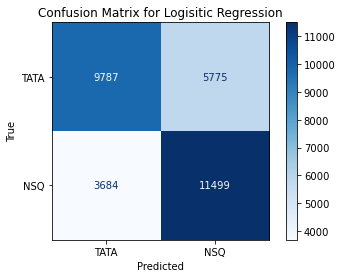

In [20]:
plot_confusion_matrix(logreg, X_test, y_test, cmap="Blues");

plt.title('Confusion Matrix for Logisitic Regression');
plt.xticks(ticks=[0, 1], labels=['TATA', 'NSQ'])
plt.yticks(ticks=[0, 1], labels=['TATA', 'NSQ'])

plt.ylabel('True')
plt.xlabel('Predicted');

* Larger rate of false positives; look to optimize; better at predicting NSQ

In [93]:
print(f'Accuracy is {accuracy_score(y_test, preds)}')
print(f'Misclassification is {1-accuracy_score(y_test, preds)}')
print(f'Recall is {recall_score(y_test, preds, pos_label=1)}')
print(f'Precision is {precision_score(y_test, preds, pos_label=1)}')
print(f'F1 score is {f1_score(y_test, preds, pos_label=1)}')

Accuracy is 0.6923402179216133
Misclassification is 0.30765978207838673
Recall is 0.7573602054929855
Precision is 0.6656825286557833
F1 score is 0.7085682595433959


In [93]:
preds = logreg.predict(X_test_cv)

In [94]:
nsq_probabilities = logreg.predict_proba(X_test_cv)[:, 1]

In [95]:
y_test_convert ={
    1: 'nsq',
    0: 'tata'
}
y_test = y_test.map(y_test_convert)

In [96]:
pred_df = pd.DataFrame({
    'true_values': y_test,
    'pred_probs': nsq_probabilities
})

In [97]:
pred_df.groupby(by='true_values').mean()

,pred_probs
true_values,
nsq,0.586750
tata,0.415804


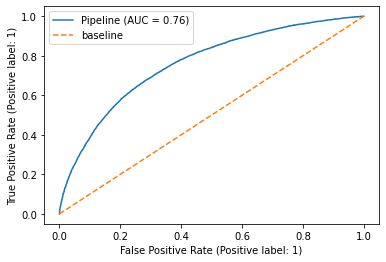

In [81]:
# ROC curve
plot_roc_curve(pipe, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label='baseline', linestyle='--')

# add a legend
plt.legend()

In [100]:
roc_auc_score(y_test, logreg.predict_proba(X_test_cv)[:,1])

0.23919147713916436

* The graph confirms that the model isn't the best but isn't the worst when trying to separate the datasets

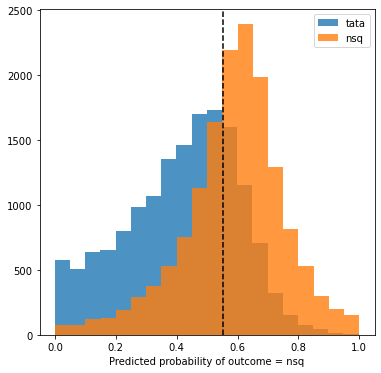

In [129]:
plt.figure(figsize=(6, 6))

tata_subset = pred_df[pred_df['true_values'] == 'tata']
plt.hist(tata_subset['pred_probs'], label='tata', bins=20, alpha=.8)

nsq_subset = pred_df[pred_df['true_values'] == 'nsq']
plt.hist(nsq_subset['pred_probs'], label='nsq', bins=20, alpha=.8)

plt.axvline(.5511, color='black', linestyle='--')
plt.xlabel('Predicted probability of outcome = nsq')

plt.legend();

* The histogram indicates that the model can definitely parse out the data for NSQ and TATA however this still quite a large overlap; corroborates with roc auc curve

In [98]:
def class_from_prob(probabilities, threshold):
    return ['tata' if prob < threshold else 'nsq' for prob in probabilities]

In [99]:
class_from_prob(pred_df['pred_probs'], threshold=.65);

In [101]:
threshold_list = [.5, .55, .5511, .64]

for threshold in threshold_list:
    predicted_classes = class_from_prob(pred_df['pred_probs'], threshold)
    acc = accuracy_score(y_test, predicted_classes)
    sens = recall_score(y_test, predicted_classes, pos_label='tata')
    print(f'''For threshold={threshold},
        accuracy={acc},
        sensitivity={sens}
        ''')

For threshold=0.5,
        accuracy=0.6923402179216133,
        sensitivity=0.6289037398791929
        
For threshold=0.55,
        accuracy=0.6956903561554725,
        sensitivity=0.7409715974810436
        
For threshold=0.5511,
        accuracy=0.6961131891364449,
        sensitivity=0.7436704793728313
        
For threshold=0.64,
        accuracy=0.6435517970401692,
        sensitivity=0.9029687700809664
        


* Changing the threshold to .5511 increases accuracy however not by much
* Overall the model is able to classify some of the text for NSQ and TATA however there is still a large overlap